In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [2]:
sql = """
SELECT
  month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

In [3]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2015-08-01,04E,C84069,1052,182.3143,83821.74
1,2015-08-01,10D,G82682,5,6.0830,45059.33
2,2015-08-01,01W,P88017,8,-24.8192,49501.65
3,2015-08-01,08N,Y02987,970,465.0991,62234.23
4,2015-08-01,08H,F83648,0,0.0000,16086.34


# Practice level data

In [4]:
practice = ghost_df.copy()
practice['calc_val'] = practice['possible_savings']/practice['net_cost']
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2010-11-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
624821,2010-11-01,00K,A81001,24,14.2020,29841.59,0.000476
46892,2010-12-01,00K,A81001,87,41.9030,30287.68,0.001383
537273,2011-01-01,00K,A81001,30,-18.5990,29670.45,-0.000627
227292,2011-02-01,00K,A81001,38,-21.5494,27586.82,-0.000781
614521,2011-03-01,00K,A81001,89,251.3024,34156.80,0.007357


# CCG level data

In [5]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = ccg['possible_savings']/ccg['net_cost']
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2010-11-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
3,00C,2010-11-01,2422,1652.8864,752002.40,0.002198
4,00C,2010-12-01,3485,4322.9984,814387.27,0.005308
5,00C,2011-01-01,2460,3528.5246,746725.43,0.004725
6,00C,2011-02-01,968,549.6110,747591.43,0.000735
7,00C,2011-03-01,3085,2274.7350,839138.56,0.002711


C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


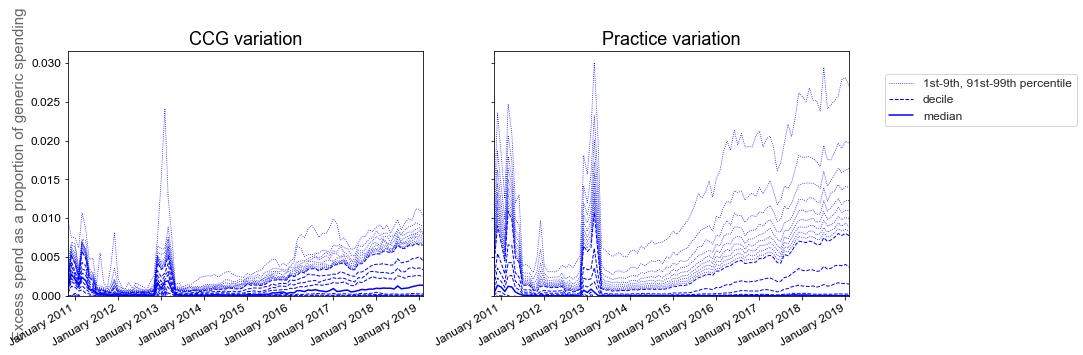

In [6]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.show()

# Most recent month map
- I think still some missing CCGs here?

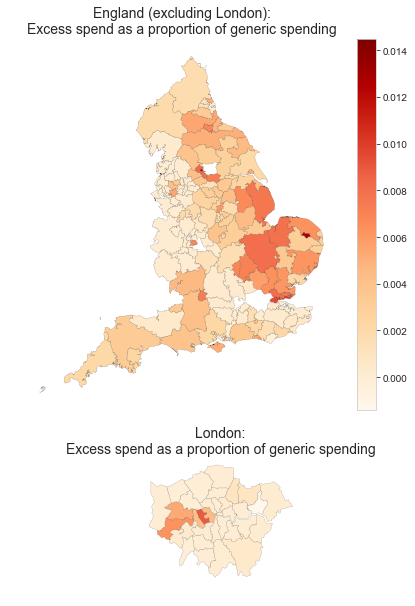

In [7]:
plt.figure(figsize=(7, 10))
last_month = ccg.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title="Excess spend as a proportion of generic spending", column='calc_val', 
             separate_london=True)
plt.show()

# Total items and total excess costs

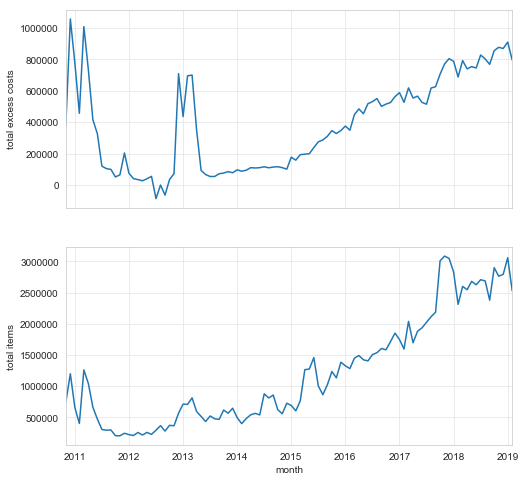

In [8]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = practice.groupby('month').sum()['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs')
ax = practice.groupby('month').sum()['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
plt.show()

# Stratify by EHR

In [9]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,TPP,SystmOne
1,A81048,TPP,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,TPP,SystmOne
4,A86026,TPP,SystmOne


In [10]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
by_epr = numbers.merge(epr, how='inner', left_on='practice', right_on='ODS')
by_epr = by_epr.groupby(['month','Principal Supplier']).sum()
by_epr = by_epr.unstack()
by_epr.head()

possible_savings                                      \
Principal Supplier             EMIS  Microtest          TPP      Vision   
month                                                                     
2010-11-01              205167.2547  -405.6494  133074.3461  20817.4751   
2010-12-01              590956.0904   -81.0722  350603.9563  55254.5589   
2011-01-01              416579.8189  -467.4578  269670.0517  48624.8674   
2011-02-01              249928.7177  -439.3642  156969.5211  25063.1928   
2011-03-01              537635.2722 -4248.3987  374247.2258  50055.2778   

                        net_cost                                         
Principal Supplier          EMIS   Microtest           TPP       Vision  
month                                                                    
2010-11-01          1.795642e+08  2783101.86  1.221164e+08  15094606.35  
2010-12-01          1.913645e+08  2965208.10  1.301516e+08  15953455.51  
2011-01-01          1.795575e+08  2719849.86  1.215787e+08  15214924.94  
2011-02-01          1.756294e+08  2717094.64  1.190238e+08  14769089.72  
2011-03-01          1.991831e+08  3047613.86  1.353099e+08  16672611.40

## Total possible savings

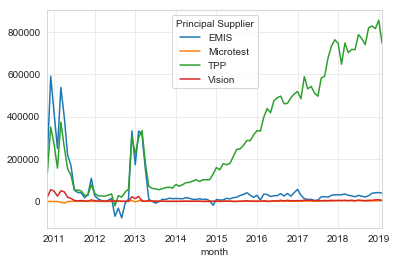

In [11]:
by_epr['possible_savings'].plot()
plt.show()

In [12]:
measure = by_epr['possible_savings'] / by_epr['net_cost']
measure.head()

Principal Supplier,EMIS,Microtest,TPP,Vision
month,,,,
2010-11-01,0.001143,-0.000146,0.001090,0.001379
2010-12-01,0.003088,-0.000027,0.002694,0.003463
2011-01-01,0.002320,-0.000172,0.002218,0.003196
2011-02-01,0.001423,-0.000162,0.001319,0.001697
2011-03-01,0.002699,-0.001394,0.002766,0.003002


## Total savings/total generic prescribing costs

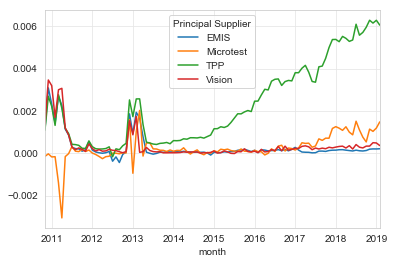

In [13]:
measure.plot()

# Map of weird spike in 2010/11

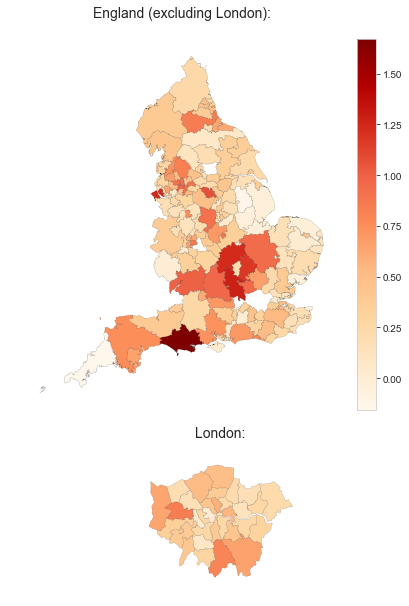

In [14]:
plt.figure(figsize=(7, 10))
weird = practice.merge(epr, how='inner', left_on='practice', right_on='ODS')
weird = weird.loc[(weird['month']>='2010-12-01') & (weird['month']<='2011-04-01')]
weird = weird.groupby('pct').sum()
maps.ccg_map(weird, title="", column='calc_val', 
             separate_london=True)
plt.show()

# Map of weird spike in 2012/13

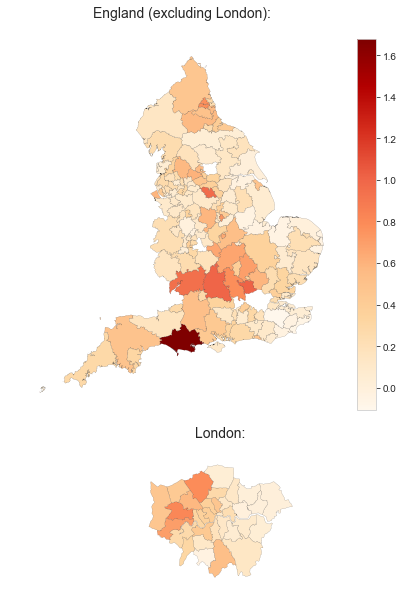

In [15]:
plt.figure(figsize=(7, 10))
weird = practice.merge(epr, how='inner', left_on='practice', right_on='ODS')
weird = weird.loc[(weird['month']>='2012-12-01') & (weird['month']<='2013-03-01')]
weird = weird.groupby('pct').sum()
maps.ccg_map(weird, title="", column='calc_val', 
             separate_london=True)
plt.show()

# Top presentations causing the weird spikes

## 2010/11

In [16]:
sql = """
SELECT
  bnf_code,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
  month >= '2010-12-01'
  AND month <= '2011-04-01'
GROUP BY
  bnf_code
ORDER BY
  possible_savings DESC
"""
by_bnf = bq.cached_read(sql, csv_path='by_bnf.zip')

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [17]:
by_bnf['calc_val'] = by_bnf['possible_savings'] / by_bnf['net_cost']
by_bnf.head()

,bnf_code,items,possible_savings,net_cost,calc_val
0,0403030Q0AAABAB,407993,1.020202e+06,3311976.29,0.308034
1,0403030D0AAAAAA,1918108,7.382023e+05,16617143.90,0.044424
2,0408010G0AAACAC,29553,5.134045e+05,932539.36,0.550545
3,0603020T0AAACAC,447815,5.116647e+05,7073123.35,0.072339
4,0403030Q0AAAAAA,302819,4.810360e+05,9298274.20,0.051734


## 2012/13

In [18]:
sql = """
SELECT
  bnf_code,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
  month >= '2012-12-01'
  AND month <= '2013-03-01'
GROUP BY
  bnf_code
ORDER BY
  possible_savings DESC
"""
by_bnf2 = bq.cached_read(sql, csv_path='by_bnf.zip')

In [19]:
by_bnf2['calc_val'] = by_bnf2['possible_savings'] / by_bnf2['net_cost']
by_bnf2.head()

,bnf_code,items,possible_savings,net_cost,calc_val
0,0403030Q0AAABAB,263951,612007.2609,3531618.17,0.173294
1,0202010P0AAAAAA,190060,482030.1624,2466489.87,0.195432
2,0401010T0AAAMAM,265972,416504.1109,8394572.88,0.049616
3,0401010T0AAANAN,76216,248136.2482,2555089.58,0.097115
4,0403010X0AAABAB,47582,182968.5589,933233.58,0.196059


# Dorset

In [20]:
pd.set_option('display.max_rows', 500)
dorset = practice.loc[practice['pct']=='11J']

## 2010/11

In [21]:
dorset_10_11 =  dorset.loc[(dorset['month']>='2010-12-01') & (dorset['month']<='2011-04-01')]
dorset_10_11 = dorset_10_11.groupby('practice').sum()
dorset_10_11.sort_values('possible_savings',ascending=False)

,items,possible_savings,net_cost,calc_val
practice,,,,
J81014,1409,4507.0789,512894.65,0.043400
J81054,685,4346.7488,281819.90,0.076307
J81077,700,2920.8223,179119.74,0.084260
J81018,957,2889.0879,350235.30,0.040153
J81059,776,2738.0509,253224.92,0.052958
J81033,1095,2633.7641,289670.91,0.044285
J81027,1524,2603.3132,561554.91,0.022022
J81041,1324,2412.8577,501995.18,0.023230
J81056,696,2375.0579,252101.80,0.045495


## 2012/13

In [22]:
dorset_12_13 =  dorset.loc[(dorset['month']>='2012-12-01') & (dorset['month']<='2013-03-01')]
dorset_12_13 = dorset_12_13.groupby('practice').sum()
dorset_12_13.sort_values('possible_savings',ascending=False)

,items,possible_savings,net_cost,calc_val
practice,,,,
J81066,2304,4257.3268,246964.76,0.067143
J81014,1190,3992.7104,369852.40,0.043066
J81006,924,3568.2033,696439.15,0.020444
J81027,914,3560.3381,486003.49,0.029518
J81018,598,3359.4809,271299.59,0.048839
J81054,343,3130.7217,201813.97,0.062081
J81065,981,2618.5487,180155.35,0.057723
J81034,1638,2383.9188,343984.65,0.027257
J81013,399,2148.4318,246077.38,0.035348
